The following notebook performs an OLS, Lasso, and Ridge regresion with all the variables, but only on primary schools. 

In [43]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

df_combined = pd.read_csv('combined_data/combined.csv')

In [44]:
df_combined = df_combined.loc[df_combined['School Level: Primary'] == 1]
df_combined = df_combined.dropna()
print('Number of rows without missing data: ', df_combined.shape[0])
print('Number of charter and traditional schools:\n', df_combined['Charter School Dummy'].value_counts())
print(list(df_combined.columns))

Number of rows without missing data:  6276
Number of charter and traditional schools:
 0    5021
1    1255
Name: Charter School Dummy, dtype: int64
['School Name', 'Agency Name', 'Agency ID - NCES Assigned', 'County Name', 'County Number', 'Charter School', 'Title I School Status', 'Congressional Code', 'National School Lunch Program', 'School Level', 'Total Students All Grades (Excludes AE)', 'Free and Reduced Lunch Students', 'Male Students', 'Female Students', 'American Indian/Alaska Native Students', 'Asian or Asian/Pacific Islander Students', 'Hispanic Students', 'Black or African American Students', 'White Students', 'Nat. Hawaiian or Other Pacific Isl. Students', 'Two or More Races Students', 'School ID - NCES Assigned', 'District Entity ID', 'District Name', 'Average Percent Passing', 'Year', 'Charter School Dummy', 'Male Students Percentage', 'Female Students Percentage', 'American Indian/Alaska Native Students Percentage', 'Asian or Asian/Pacific Islander Students Percentage'

In [45]:
# columns to be used for analysis
X = df_combined[['Charter School Dummy', 'Total Students All Grades (Excludes AE)', 'Free and Reduced Lunch Students Percentage', 
                'Female Students Percentage', 'American Indian/Alaska Native Students Percentage', 
                'Asian or Asian/Pacific Islander Students Percentage', 'Hispanic Students Percentage', 
                'Black or African American Students Percentage', 
                'Nat. Hawaiian or Other Pacific Isl. Students Percentage', 'Two or More Races Students Percentage', 
                '2015', '2016', '2017', '2018', '2019']]
y = df_combined[['Average Percent Passing']]

# normalizes the predictor variables
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# splits the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.20)

# performs OLS regression and summarizes regression
olsReg = sm.OLS(y_train,X_train).fit()
print(olsReg.summary())

# uses regression to predict with test data
y_pred = olsReg.predict(X_test)

# compares the predicted values to the actual values to evaluate model performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('R-squared:', r2)
print('Mean squared error:', mse)

                                   OLS Regression Results                                   
Dep. Variable:     Average Percent Passing   R-squared (uncentered):                   0.935
Model:                                 OLS   Adj. R-squared (uncentered):              0.935
Method:                      Least Squares   F-statistic:                              4814.
Date:                     Thu, 23 Mar 2023   Prob (F-statistic):                        0.00
Time:                             20:12:30   Log-Likelihood:                         -19386.
No. Observations:                     5020   AIC:                                  3.880e+04
Df Residuals:                         5005   BIC:                                  3.890e+04
Df Model:                               15                                                  
Covariance Type:                 nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025    

Best Alpha:  1e-06
MSE:  133.07110909860464


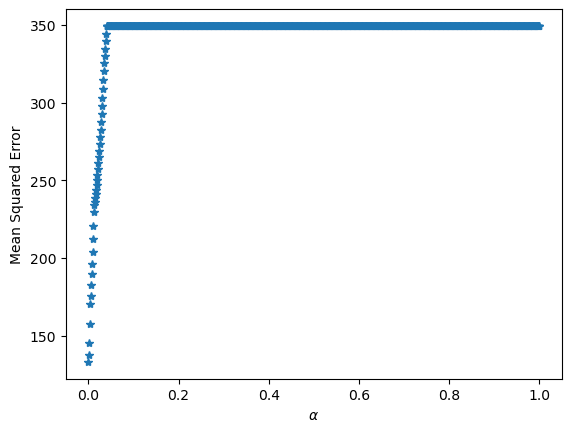

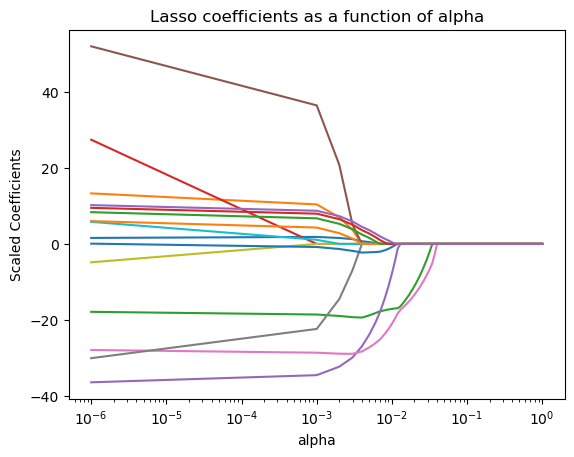

In [46]:
# constructs vector of alpha values
alphas = np.linspace(1e-6, 1, num=1000)

# constructs vectors to store mean prediction errors and coefficients
cv_errs = []
lasso_coefs = []
MSE = 500
bestalpha = 0

# loops for running ridge regression for different values of alpha
for a in alphas:
    lassoReg = make_pipeline(Lasso(alpha=a * np.sqrt(X_train.shape[0])))
    lassoReg.fit(X_train, y_train)
    y_pred = lassoReg.predict(X_test)
    cv_errs.append(mean_squared_error(y_test, y_pred))
    lasso_coefs.append(lassoReg['lasso'].coef_)
    if mean_squared_error(y_test, y_pred) < MSE: 
        MSE = mean_squared_error(y_test, y_pred)
        bestalpha = a

best_lasso_coefs = lasso_coefs[cv_errs.index(min(cv_errs))]
    
print("Best Alpha: ", bestalpha)
print("MSE: ", MSE)

# plots the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.show()

ax = plt.gca()
ax.plot(alphas, lasso_coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Scaled Coefficients')
plt.title('Lasso coefficients as a function of alpha');

Best Alpha:  1e-06
MSE:  133.0702615728516


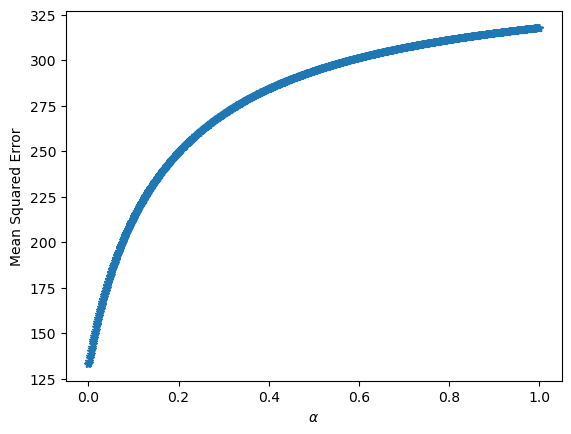

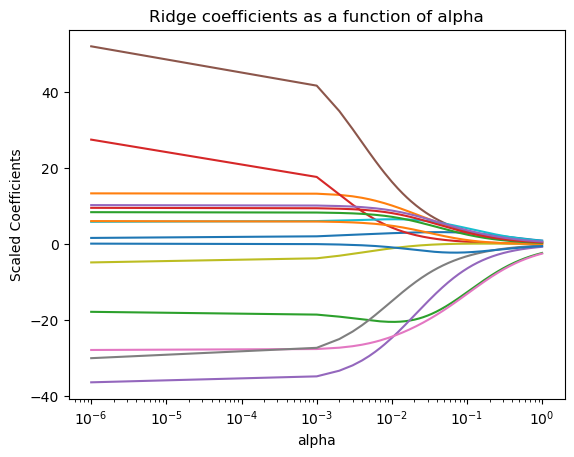

In [47]:
# constructs vector of alpha values
alphas = np.linspace(1e-6, 1, num=1000)

# constructs vectors to store mean prediction errors and coefficients
cv_errs = []
ridge_coefs = []
MSE = 500
bestalpha = 0

# loops for running ridge regression for different values of alpha
for a in alphas:
    ridgeReg = make_pipeline(Ridge(alpha=a * X_train.shape[0]))
    ridgeReg.fit(X_train, y_train)
    y_pred = ridgeReg.predict(X_test)
    cv_errs.append(mean_squared_error(y_test, y_pred))
    ridge_coefs.append(ridgeReg['ridge'].coef_)
    if mean_squared_error(y_test, y_pred) < MSE: 
        MSE = mean_squared_error(y_test, y_pred)
        bestalpha = a

best_ridge_coefs = ridge_coefs[cv_errs.index(min(cv_errs))]
    
print("Best Alpha: ", bestalpha)
print("MSE: ", MSE)

# plots the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.show()

# plots the coefficients over alpha values
ax = plt.gca()
ax.plot(alphas, np.squeeze(ridge_coefs))
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Scaled Coefficients')
plt.title('Ridge coefficients as a function of alpha');

In [49]:
# coef_comp = pd.DataFrame({'var': X.columns.tolist(), 
#                           'val_ols': olsReg.params.tolist(),
#                           'val_lasso': best_lasso_coefs,
#                           'val_ridge': best_ridge_coefs[0]})
# print(coef_comp)

# creates new data frame with coefficients
coef_comp = pd.DataFrame({
    'Variable': X.columns.tolist(),
    'Primary': olsReg.params.round(3),
})

# sets index to variable name
coef_comp.set_index('Variable', inplace=True)

# formats the table for Latex
print(coef_comp.style.format("{:.3f}").to_latex())

\begin{tabular}{lr}
 & Primary \\
Variable &  \\
Charter School Dummy & 1.084 \\
Total Students All Grades (Excludes AE) & 16.840 \\
Free and Reduced Lunch Students Percentage & -16.118 \\
Female Students Percentage & 101.642 \\
American Indian/Alaska Native Students Percentage & -33.665 \\
Asian or Asian/Pacific Islander Students Percentage & 55.268 \\
Hispanic Students Percentage & -25.320 \\
Black or African American Students Percentage & -28.924 \\
Nat. Hawaiian or Other Pacific Isl. Students Percentage & -2.138 \\
Two or More Races Students Percentage & 11.911 \\
2015 & 2.236 \\
2016 & 7.768 \\
2017 & 9.945 \\
2018 & 10.927 \\
2019 & 11.538 \\
\end{tabular}

